# [emoji](https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo#sample-lstm-code-sentiment-analysis-)
## [dataset](https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo/tree/master/SentimentAnalysisProject)

In [1]:
!pip install torchtext

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#!pip install -U spacy
!!pip install -U 'spacy[cuda12x]'

['Defaulting to user installation because normal site-packages is not writeable',
 'Requirement already satisfied: spacy[cuda12x] in /home/ubuntu/.local/lib/python3.10/site-packages (3.7.5)',
 'Requirement already satisfied: preshed<3.1.0,>=3.0.2 in /home/ubuntu/.local/lib/python3.10/site-packages (from spacy[cuda12x]) (3.0.9)',
 'Requirement already satisfied: packaging>=20.0 in /home/ubuntu/.local/lib/python3.10/site-packages (from spacy[cuda12x]) (24.1)',
 'Requirement already satisfied: requests<3.0.0,>=2.13.0 in /home/ubuntu/.local/lib/python3.10/site-packages (from spacy[cuda12x]) (2.32.3)',
 'Requirement already satisfied: weasel<0.5.0,>=0.1.0 in /home/ubuntu/.local/lib/python3.10/site-packages (from spacy[cuda12x]) (0.4.1)',
 'Requirement already satisfied: murmurhash<1.1.0,>=0.28.0 in /home/ubuntu/.local/lib/python3.10/site-packages (from spacy[cuda12x]) (1.0.10)',
 'Requirement already satisfied: wasabi<1.2.0,>=0.9.1 in /home/ubuntu/.local/lib/python3.10/site-packages (from s

In [3]:
!python3 -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
!pip install cupy-cuda12x

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import spacy

spacy.require_gpu()
spacy_en = spacy.load("en_core_web_sm")
spacy_en.disable_pipes(*[pipe for pipe in spacy_en.pipe_names if pipe != "tokenizer"])

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [6]:
def tokenizer_en(text):
    doc = spacy_en(text)
    tokens = [token.text.lower() for token in doc]
    return tokens

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
!curl -o test_emoji.csv https://raw.githubusercontent.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo/master/SentimentAnalysisProject/test_emoji.csv 
!curl -o train_emoji.csv https://raw.githubusercontent.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo/master/SentimentAnalysisProject/train_emoji.csv 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1426  100  1426    0     0   3003      0 --:--:-- --:--:-- --:--:--  3008
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3542  100  3542    0     0   7257      0 --:--:-- --:--:-- --:--:--  7258


In [9]:
import pandas as pd

df_train = pd.read_csv('train_emoji.csv', header=None, usecols=[0, 1], names=['text', 'emoji'])
df_test = pd.read_csv('test_emoji.csv', header=None, usecols=[0, 1], names=['text', 'emoji'])

In [10]:
df_train.head()

,text,emoji
0,never talk to me again,3
1,I am proud of your achievements,2
2,It is the worst day in my life,3
3,Miss you so much,0
4,food is life,4


In [11]:
df_train.describe()

,emoji
count,132.000000
mean,2.053030
std,1.268012
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [12]:
n = 100
row = df_train.iloc[n]
print(row.text)
print(row.emoji)

I love my dad
0


In [13]:
import os
import random
import numpy as np
import torch
import torchvision

In [14]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [15]:
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [16]:
from typing import List, Tuple

def yield_tokens(data_iter: pd.Series) -> List[str]:
    for text in data_iter:
        yield tokenizer_en(text)

In [17]:
from torchtext.vocab import build_vocab_from_iterator

text_vocab = build_vocab_from_iterator(yield_tokens(df_train['text']), specials=['<unk>'])
text_vocab.set_default_index(text_vocab['<unk>'])

/home/ubuntu/.local/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/.local/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [18]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

class EmojiAuthorDataset(Dataset):
    def __init__(self, df: pd.DataFrame, text_vocab):
        self.df = df
        self.text_vocab = text_vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item  =self.df.iloc[idx]
        return {
            'text': torch.tensor([self.text_vocab[token] for token in tokenizer_en(item['text'])]),
            'emoji': torch.tensor(item['emoji'])
        }  


In [19]:
from torch.utils.data import random_split

train_data = EmojiAuthorDataset(df_train, text_vocab)
test_data = EmojiAuthorDataset(df_test, text_vocab)

In [20]:
print('훈련 샘플의 개수 : {}'.format(len(train_data)))
print('테스트 샘플의 개수 : {}'.format(len(test_data)))

훈련 샘플의 개수 : 132
테스트 샘플의 개수 : 56


In [21]:
print(train_data[0])

{'text': tensor([194, 236,  10,  17,  52]), 'emoji': tensor(3)}


In [22]:
print('단어 집합의 크기 : {}'.format(len(text_vocab)))

단어 집합의 크기 : 260


In [23]:
print(text_vocab.get_stoi())

{'yes': 258, 'wrong': 257, 'killing': 174, 'congrats': 120, 'humiliated': 167, 'incredibly': 170, 'think': 240, 'charming': 113, 'favorite': 140, 'celebrate': 112, 'but': 108, 'with': 82, 'by': 56, 'talk': 236, 'awful': 102, 'you': 2, 'job': 30, 'always': 92, 'lol': 72, 'alone': 91, 'likes': 71, 'proud': 76, 'bullshit': 107, 'her': 67, 'afternoon': 89, 'adorable': 86, 'get': 149, 'working': 83, 'of': 32, 'sushi': 233, 'come': 118, 'an': 94, 'achievements': 85, 'stadium': 79, 'joke': 42, 'two': 81, 'shouting': 77, 'puppies': 210, 'code': 117, 'stop': 48, 'healthy': 161, 'new': 195, 'chinese': 116, 'fun': 64, 'stupidity': 229, 'day': 59, 'sucks': 232, 'smiles': 223, 'anything': 97, 'dad': 126, 'going': 153, 'excited': 62, 'did': 22, 'position': 208, 'project': 209, 'zero': 259, 'happy': 66, 'when': 253, 'ha': 25, 'congratulations': 58, 'rules': 214, 'will': 51, 'said': 217, 'food': 23, 'too': 80, 'candy': 110, 'talented': 235, 'girl': 150, 'dog': 133, 'your': 21, 'guy': 156, 'best': 105,

In [24]:
print(text_vocab.get_itos())

['<unk>', 'i', 'you', 'is', 'the', 'a', 'am', 'so', 'are', 'my', 'to', 'for', 'he', 'she', 'this', 'not', 'it', 'me', 'do', 'love', 'want', 'your', 'did', 'food', 'got', 'ha', 'have', 'was', 'baseball', 'funny', 'job', 'like', 'of', 'that', 'at', 'bad', 'cute', 'down', 'game', 'good', 'great', 'him', 'joke', 'lets', 'life', 'lot', 'miss', 'on', 'stop', 'what', 'who', 'will', 'again', 'and', 'ball', 'bravo', 'by', 'can', 'congratulations', 'day', 'dinner', 'dogs', 'excited', 'forever', 'fun', 'had', 'happy', 'her', 'how', 'in', 'just', 'likes', 'lol', 'long', 'no', 'player', 'proud', 'shouting', 'smile', 'stadium', 'too', 'two', 'with', 'working', 'acceptance', 'achievements', 'adorable', 'adore', 'after', 'afternoon', 'algorithm', 'alone', 'always', 'amazing', 'an', 'announcement', 'answer', 'anything', 'approved', 'ask', 'assignment', 'attractive', 'awful', 'baby', 'base', 'best', 'brunch', 'bullshit', 'but', 'cake', 'candy', 'catcher', 'celebrate', 'charming', 'cheese', 'chicago', 'c

In [25]:
batch_size = 5

In [26]:
def collate_batch(batch):
    label_list, text_list = [], []
    for item in batch:
        label_list.append(item['emoji'])
        text_list.append(item['text'])
    
    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=text_vocab['<pad>'])
    label_list = torch.tensor(label_list, dtype=torch.int64)
    return text_list, label_list


In [27]:
train_loader = DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)

In [28]:
print('훈련 데이터의 미니 배치 수 : {}'.format(len(train_loader)))
print('테스트 데이터의 미니 배치 수 : {}'.format(len(test_loader)))

훈련 데이터의 미니 배치 수 : 27
테스트 데이터의 미니 배치 수 : 12


In [29]:
for text, emoji in train_loader:
    print(text)
    print(emoji)
    break

tensor([[227,  31,   5,  64, 202,  25,  25,   0,   0],
        [ 49,   5,  64, 191,   0,   0,   0,   0,   0],
        [  1,   6,  76,  32,  21,  85,   0,   0,   0],
        [  1,   6, 247, 132,   0,   0,   0,   0,   0],
        [  7,  35,  33,   2,  57,  15, 118,  82, 245]])
tensor([2, 2, 2, 3, 3])


In [30]:
print(text.shape)
print(emoji.shape)

torch.Size([5, 9])
torch.Size([5])


In [31]:
labels = set(df_train['emoji'])
labels

{0, 1, 2, 3, 4}

In [32]:
seq_length = 20
embed_dim = 128
n_layers = 3
n_vocab = len(text_vocab.get_stoi())

hidden_size = 128
output_size = len(labels)

In [33]:
class EmojiModel(nn.Module):
    def __init__(self, embed_dim, hidden_size, output_size, n_layers, device):
        super(EmojiModel, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.device = device

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.rnn = nn.GRU(input_size=embed_dim, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, output_size)
        )        
    def forward(self, x):
        batch_size = x.shape[0]
        hidden = torch.zeros(n_layers, batch_size, self.hidden_size).to(device)  
        x = self.embed(x)
        x, hidden = self.rnn(x, hidden)
#        hidden = hidden[-1] # 마지막 레이어만 사용
#        output = self.fc(hidden)
        x = x[:,-1,:]
        output = self.fc(x)
        return output

In [34]:
import numpy as np

model = EmojiModel(embed_dim, hidden_size, output_size, n_layers, device).to(device)
X = torch.LongTensor(text).to(device)
with torch.no_grad():
    y_pred = model(X)
    print(y_pred)
    print(np.argmax(y_pred.cpu(), axis=1), emoji)

tensor([[ 0.0681,  0.1042, -0.1374, -0.7158, -0.3035],
        [-0.1272, -0.3938, -0.7144,  1.2640,  0.4183],
        [ 0.0432,  0.1638,  0.6185,  0.5472, -0.2544],
        [ 0.9121,  0.4036,  0.4484, -0.1696,  0.1388],
        [-0.0799,  0.8648,  0.2473,  0.7971, -0.4346]], device='cuda:0')
tensor([1, 3, 2, 0, 1]) tensor([2, 2, 2, 3, 3])


In [35]:
batch_size = 10
model = EmojiModel(embed_dim, hidden_size, output_size, n_layers, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss().to(device)

n_epochs = 200 # 200회 학습

list_training_loss = []
list_test_loss = []

for epoch in range(n_epochs):
    n_train = 0
    train_loss = 0

    train_loader = DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)
    test_loader = DataLoader(dataset=test_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)

    model.train()
    for text, emoji in train_loader:
        train_d = text
        train_d = torch.LongTensor(train_d).to(device)
        train_t = torch.LongTensor(emoji).to(device)
        y = model(train_d)
        del train_d
        loss = criterion(y, train_t).sum()
        train_loss += loss.data.cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_train += len(train_t)
        del train_t

    if (epoch + 1) % 10 == 0:
        model.eval()
        n_test = 0
        test_loss = 0
        correct = 0
        total = 0
        
        for text, emoji in test_loader:
            test_d = text
            test_d = torch.LongTensor(test_d).to(device)
            test_t = torch.LongTensor(emoji).to(device)
            y_pred = model(test_d)
            idx_pred = torch.max(y_pred, 1)[1]
            del test_d
            loss = criterion(y_pred, test_t).sum()
            test_loss += loss.data.cpu().numpy()
            n_test += len(test_t)
            correct += (idx_pred == test_t).sum()
            del test_t

        accuracy = correct * 100 / n_test
        print('epoch {}th training loss: {} test loss: {}, accuracy: {}'.format(
                epoch + 1, train_loss / n_train, test_loss / n_test,
                accuracy
            ))
        list_training_loss.append(train_loss / n_train)
        list_test_loss.append(test_loss / n_test)

epoch 10th training loss: 0.12910223774837726 test loss: 0.2528012543916702, accuracy: 50.000003814697266
epoch 20th training loss: 0.06091374844651331 test loss: 0.20695323177746364, accuracy: 51.78571701049805
epoch 30th training loss: 0.018927353818787997 test loss: 0.28106733730861116, accuracy: 51.78571701049805
epoch 40th training loss: 0.025774690827485316 test loss: 0.4326671234198979, accuracy: 46.42857360839844
epoch 50th training loss: 0.0374217831783674 test loss: 0.37062613878931316, accuracy: 44.642860412597656
epoch 60th training loss: 0.01274820810596628 test loss: 0.4275691381522587, accuracy: 46.42857360839844
epoch 70th training loss: 0.019043146724332913 test loss: 0.36555942467280794, accuracy: 51.78571701049805
epoch 80th training loss: 0.03304595787454728 test loss: 0.5042619109153748, accuracy: 50.000003814697266
epoch 90th training loss: 0.04196415313223648 test loss: 0.5319166885954993, accuracy: 51.78571701049805
epoch 100th training loss: 0.02017722883222935

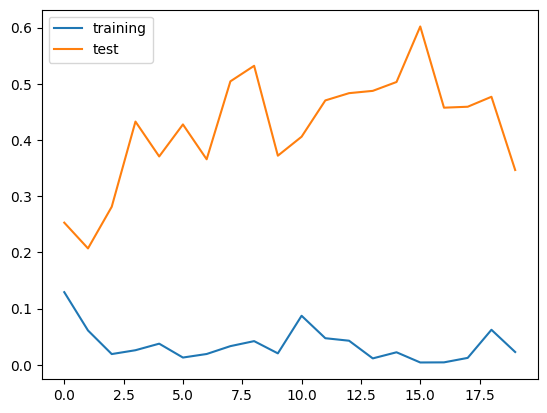

In [36]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()